# Simple GP Regression with an RBF Kernel

## Introduction

In this notebook, we demonstrate many of the design features of GPyTorch using the simplest example, training an RBF kernel Gaussian process on a simple function. We'll be modeling the function $$y = \sin(2\pi x) + \epsilon$$ $$\epsilon \sim \mathcal{N}(0, 0.2)$$ with 11 training examples, and testing on 51 test examples.

**Note:** this notebook is not necessarily intended to teach the mathematical background of Gaussian processes, but rather how to train a simple one and make predictions in GPyTorch. For a mathematical treatment, Chapter 2 of Gaussian Processes for Machine Learning provides a very thorough introduction to GP regression (this entire text is highly recommended): http://www.gaussianprocess.org/gpml/chapters/RW2.pdf

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [10]:
from torch import optim
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.priors import SmoothedBoxPrior
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

## Set up training data

In the next cell, we set up the training data for this example. We'll be using 11 regularly spaced points on [0,1] which we evaluate the function on and add Gaussian noise to get the training labels.

In [11]:
# Training data is 11 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 11)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2

## Setting up the model

The next cell demonstrates the most critical features of a user-defined Gaussian process model in GPyTorch. Building a GP model in GPyTorch is different in a number of ways.

First in contrast to many existing GP packages, we do not provide full GP models for the user. Rather, we provide *the tools necessary to quickly construct one*. This is because we believe, analogous to building a neural network in standard PyTorch, it is important to have the flexibility to include whatever components are necessary. As can be seen in more complicated examples, like the `dkl_mnist.ipynb` example which combines deep learning and Gaussian processes, this allows the user great flexibility in designing custom models.

The components of a user built (Exact, i.e. non-variational) GP model in GPyTorch are, broadly speaking:

1. An `__init__` method that takes the training data and a likelihood, and constructs whatever objects are necessary for the model's `forward` method. This will most commonly include things like a mean module and a kernel module, but may also include things like extra parameters, such as a log outputscale that we will see in later examples.

2. A `forward` method that takes in some $n \times d$ data `x` and returns a GaussianRandomVariable with the *prior* mean and covariance evaluated at `x`. In other words, we return the vector $\mu(x)$ and the $n \times n$ matrix $K_{xx}$ representing the prior mean and covariance matrix of the GP. 

This specification leaves a large amount of flexibility when defining a model. For example, to compose two kernels via addition, you can either add the kernel modules directly:

```python
self.covar_module = RBFKernel() + WhiteNoiseKernel()
```

Or you can add the outputs of the kernel in the forward method:

```python
covar_x = self.rbf_kernel_module(x) + self.white_noise_module(x)
```

In [12]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        # Let's also place a prior over the log lengthscale to demonstrate that interface.
        self.covar_module = RBFKernel(log_lengthscale_prior=SmoothedBoxPrior(math.exp(-5), math.exp(6), sigma=0.1, log_transform=True))
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return GaussianRandomVariable(mean_x, covar_x)

# initialize likelihood and model
likelihood = GaussianLikelihood()
model = ExactGPModel(train_x.data, train_y.data, likelihood)

## Training the model

In the next cell, we handle using Type-II MLE to train the hyperparameters of the Gaussian process.

The most obvious difference here compared to many other GP implementations is that, as in standard PyTorch, the core training loop is written by the user. In GPyTorch, we make use of the standard PyTorch optimizers as from `torch.optim`, and all trainable parameters of the model should be of type `torch.nn.Parameter`. Because GP models directly extend `torch.nn.Module`, calls to methods like `model.parameters()` or `model.named_parameters()` function as you might expect coming from PyTorch.

In most cases, the boilerplate code below will work well. It has the same basic components as the standard PyTorch training loop:

1. Zero all parameter gradients
2. Call the model and compute the loss
3. Call backward on the loss to fill in gradients
4. Take a step on the optimizer

However, defining custom training loops allows for greater flexibility. For example, it is easy to save the parameters at each step of training, or use different learning rates for different parameters (which may be useful in deep kernel learning for example).

In [13]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f   log_noise: %.3f' % (
        i + 1, training_iter, loss.data[0],
        model.covar_module.log_lengthscale.data[0, 0],
        model.likelihood.log_noise.data[0]
    ))
    optimizer.step()

Iter 1/50 - Loss: 7.250   log_lengthscale: 0.000   log_noise: 0.000
Iter 2/50 - Loss: 7.217   log_lengthscale: -0.100   log_noise: -0.100
Iter 3/50 - Loss: 7.187   log_lengthscale: -0.199   log_noise: -0.200
Iter 4/50 - Loss: 7.158   log_lengthscale: -0.299   log_noise: -0.299
Iter 5/50 - Loss: 7.132   log_lengthscale: -0.399   log_noise: -0.398
Iter 6/50 - Loss: 7.107   log_lengthscale: -0.499   log_noise: -0.498
Iter 7/50 - Loss: 7.086   log_lengthscale: -0.587   log_noise: -0.596
Iter 8/50 - Loss: 7.068   log_lengthscale: -0.659   log_noise: -0.693
Iter 9/50 - Loss: 7.051   log_lengthscale: -0.739   log_noise: -0.790
Iter 10/50 - Loss: 7.035   log_lengthscale: -0.825   log_noise: -0.887
Iter 11/50 - Loss: 7.019   log_lengthscale: -0.916   log_noise: -0.984
Iter 12/50 - Loss: 7.004   log_lengthscale: -1.009   log_noise: -1.081
Iter 13/50 - Loss: 6.994   log_lengthscale: -1.105   log_noise: -1.179
Iter 14/50 - Loss: 6.991   log_lengthscale: -1.204   log_noise: -1.278
Iter 15/50 - Loss

## Make predictions with the model

In the next cell, we make predictions with the model. To do this, we simply put the model and likelihood in eval mode, and call both modules on the test data.

Just as a user defined GP model returns a GaussianRandomVariable containing the prior mean and covariance from forward, a trained GP model in eval mode returns a GaussianRandomVariable containing the posterior mean and covariance. Thus, getting the predictive mean and variance, and then sampling functions from the GP at the given test points could be accomplished with calls like:

```python
f_preds = model(test_x)
y_preds = likelihood(model(test_x))
f_mean = f_preds.mean()
f_var = f_preds.var()
f_covar = f_preds.covar()
f_samples = f_preds.sample(1000)
```

The `gpytorch.fast_pred_var` context is not needed, but here we are giving a preview of using one of our cool features, getting faster predictive distributions using LOVE (https://arxiv.org/abs/1803.06058).

In [14]:
# Put model and likelihood into eval mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
test_x = torch.linspace(0, 1, 51)
# Make predictions by feeding model through likelihood
with gpytorch.fast_pred_var():
    observed_pred = likelihood(model(test_x))

## Plot the model fit

In the next cell, we plot the mean and confidence region of the Gaussian process model. The `confidence_region` method is a helper method that returns 2 standard deviations above and below the mean.

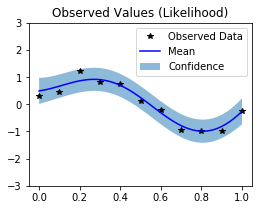

In [15]:
# Initialize plot
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))

# Define plotting function
def ax_plot(ax, rand_var, title):
    # Get upper and lower confidence bounds
    lower, upper = rand_var.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)
# Plot the predictions
ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')